# LeNet Lab
![LeNet Architecture](lenet.png)
Source: Yan LeCun

## Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

You do not need to modify this section.

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))

'''
Ideas to try:

put the more sparse data samples, more in the model, may double them
do a layer 32x32x3 --> 
make the layers deeper on the convolutional layers

'''

def bing():
	import pygame
	import time

	pygame.mixer.init()
	soundObj = pygame.mixer.Sound('beep1.ogg')
	soundObj.play()

	time.sleep(2)
	soundObj.stop()




Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

You do not need to modify this section.

#We plot the number of each labels in the training set to get a distribution, notice almost half of the samples have under 500 training images. This may call for making repeats or data augmentation.

In [2]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
count = Counter(y_train)
x = [i for i in range(43)]

x_arr = [count[i] for i in range(43)]
print(count, len(count))
plt.scatter(x,x_arr)

Counter({2: 2010, 1: 1980, 13: 1920, 12: 1890, 38: 1860, 10: 1800, 4: 1770, 5: 1650, 25: 1350, 9: 1320, 7: 1290, 3: 1260, 8: 1260, 11: 1170, 18: 1080, 35: 1080, 17: 990, 14: 690, 31: 690, 33: 599, 15: 540, 26: 540, 28: 480, 23: 450, 30: 390, 6: 360, 16: 360, 34: 360, 22: 330, 36: 330, 20: 300, 40: 300, 21: 270, 39: 270, 24: 240, 29: 240, 27: 210, 32: 210, 41: 210, 42: 210, 0: 180, 19: 180, 37: 180}) 43


In [3]:
'''
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
'''

low_number_data_points = []
for i in count:
    #print(i, count[i])
    if count[i] < 400:
        low_number_data_points.append( i )
'''    
print(low_number_data_points, len(low_number_data_points))
print(y_test[:10])
'''
print(len(X_train), len(y_train) )
import time

start = time.time()
X_train = X_train.tolist()
y_train = y_train.tolist()
fina = time.time()
print("done", (fina- start))

for i in range(len(X_train)):
    if i % 2000 == 0:
        print(i, "Here")
    if y_train[i] in low_number_data_points:
        
        for _ in range(3):
            X_train.append( X_train[i] )        
            y_train.append( y_train[i] )
    
    
#print(len(X_train), len(y_train) )
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
#bing()


34799 34799
done 23.253536462783813
0 Here
1000 Here
2000 Here
3000 Here
4000 Here
5000 Here
6000 Here
7000 Here
8000 Here
9000 Here
10000 Here
11000 Here
12000 Here
13000 Here
14000 Here
15000 Here
16000 Here
17000 Here
18000 Here
19000 Here
20000 Here
21000 Here
22000 Here
23000 Here
24000 Here
25000 Here
26000 Here
27000 Here
28000 Here
29000 Here
30000 Here
31000 Here
32000 Here
33000 Here
34000 Here


In [4]:
print(type(X_train), X_train[-1],y_train[-1])

<class 'numpy.ndarray'> [[[133 150 180]
  [133 150 179]
  [133 149 177]
  ...
  [124 137 163]
  [124 138 165]
  [122 137 164]]

 [[132 149 178]
  [134 149 177]
  [131 147 175]
  ...
  [124 137 162]
  [122 136 161]
  [122 137 163]]

 [[129 146 173]
  [130 145 173]
  [129 145 172]
  ...
  [123 137 164]
  [123 136 162]
  [122 136 160]]

 ...

 [[ 60  60  66]
  [ 63  67  77]
  [ 70  73  82]
  ...
  [ 31  31  33]
  [ 37  36  37]
  [ 37  35  36]]

 [[ 63  65  69]
  [ 66  71  76]
  [ 75  79  86]
  ...
  [ 29  28  29]
  [ 32  29  30]
  [ 31  29  29]]

 [[ 59  60  61]
  [ 61  64  68]
  [ 70  75  85]
  ...
  [ 28  26  26]
  [ 31  27  28]
  [ 31  28  29]]] 20


Normalize the dataset: do (pointR - 128.0)/128.0

In [5]:


def vecI(vec):
    return (vec-128.)/128



X_train = [vecI(i) for i in X_train ]
X_valid = [vecI(i) for i in X_valid ]
X_test = [vecI(i) for i in X_test ]
#print(X_train[0])


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt


index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

#plt.figure(figsize=(1,1))
#plt.imshow(image)


## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [7]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [8]:
import tensorflow as tf

EPOCHS = 15
BATCH_SIZE = 512

## TODO: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [10]:
from tensorflow.contrib.layers import flatten

def LeNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #Layer 0:    
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16.
    
    # 6 to 64
    weight_layer_1 = tf.Variable(tf.truncated_normal((5,5, 3, 32),mu,sigma))
    bias_1 = tf.Variable(tf.zeros(32))
    # TODO: Activation.
    layer_1 = tf.nn.conv2d(x, weight_layer_1, [1,1,1,1], padding='VALID') + bias_1
    layer_1 = tf.nn.relu(layer_1)
    
    # TODO: Pooling. Input = 28x28x16. Output = 14x14x16.   
    # can also do stride = 2 with padding SAME 
    
    layer_1 = tf.nn.max_pool(layer_1,
                             ksize=[1, 2,2, 1],
                             strides=[1, 2,2, 1],
                           padding='VALID')
    
    
    # TODO: Layer 2: Convolutional. Output = 10x10x32.
    
    weight_layer_2 = tf.Variable(tf.truncated_normal((5,5, 32, 64),mu,sigma))
    bias_2 = tf.Variable(tf.zeros(64))
    layer_2 = tf.nn.conv2d(layer_1, weight_layer_2, 
                           strides=[1, 1, 1, 1], padding='VALID') + bias_2
    layer_2 = tf.nn.relu(layer_2)
    
    # TODO: Pooling. Input = 10x10x32. Output = 5x5x32.
    layer_2 = tf.nn.max_pool(layer_2,
                             ksize=[1, 2,2, 1],
                             strides=[1,2,2, 1],
                            padding='VALID')
    
    # TODO: Flatten. Input = 5x5x32. Output = 800.  
    
    layer_2 = flatten(layer_2)  
    #t = input()
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    #print(layer_2.shape)
    weight_layer_3 = tf.Variable(tf.truncated_normal((1600,400),mu,sigma))
    bias_3 = tf.Variable( tf.zeros(400) )
    l3_fc1 = tf.matmul(layer_2, weight_layer_3) + bias_3
    
    l3_fc1 = tf.nn.dropout(l3_fc1,keep_prob)
    
    # TODO: Activation.
    l3_fc1 = tf.nn.relu(l3_fc1)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    weight_layer_4 = tf.Variable(tf.truncated_normal((400,84),mu,sigma))
    bias_4 = tf.Variable(tf.zeros(84))
    l4_fc2 = tf.matmul(l3_fc1, weight_layer_4) + bias_4
    
    # TODO: Activation.
    l4_fc2 = tf.nn.dropout(l4_fc2,keep_prob)
    l4_fc2 = tf.nn.relu(l4_fc2)
    
    
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    weight_layer_5 = tf.Variable(tf.truncated_normal((84,43),mu,sigma))
    bias_5 = tf.Variable(tf.zeros(43))    
    logits = tf.matmul(l4_fc2, weight_layer_5) +  bias_5
    # TODO: Activation.
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x,keep_prob)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, keep_proba):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob : keep_proba})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return (total_accuracy / num_examples, total_loss / num_examples)

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [12]:
import time

start = time.time()
valid_accuracy_arr = []
loss_arr = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : .7})
            
        validation_accuracy = evaluate(X_valid, y_valid,1)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}, loss = {:.3f}".format(validation_accuracy[0], validation_accuracy[1]))
        print()
        valid_accuracy_arr.append(validation_accuracy[0])
        loss_arr.append(validation_accuracy[1])
        
    saver.save(sess, './lenet')
    print("Model saved")
fina = time.time()
print("it took", (fina-start)," to train")

Training...

EPOCH 1 ...
Validation Accuracy = 0.658, loss = 1.330

EPOCH 2 ...
Validation Accuracy = 0.882, loss = 0.472

EPOCH 3 ...
Validation Accuracy = 0.918, loss = 0.303

EPOCH 4 ...
Validation Accuracy = 0.925, loss = 0.259

EPOCH 5 ...
Validation Accuracy = 0.932, loss = 0.251

EPOCH 6 ...
Validation Accuracy = 0.943, loss = 0.200

EPOCH 7 ...
Validation Accuracy = 0.944, loss = 0.204

EPOCH 8 ...
Validation Accuracy = 0.950, loss = 0.193

EPOCH 9 ...
Validation Accuracy = 0.950, loss = 0.194

EPOCH 10 ...
Validation Accuracy = 0.951, loss = 0.209

EPOCH 11 ...
Validation Accuracy = 0.946, loss = 0.204

EPOCH 12 ...
Validation Accuracy = 0.951, loss = 0.201

EPOCH 13 ...
Validation Accuracy = 0.949, loss = 0.199

EPOCH 14 ...
Validation Accuracy = 0.954, loss = 0.169

EPOCH 15 ...
Validation Accuracy = 0.959, loss = 0.176

Model saved
it took 1065.8593308925629  to train


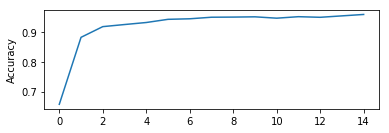

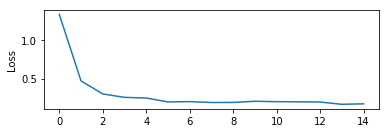

In [13]:
'''
All data and 2 epochs took 62 seconds

'''

plt.figure(1)
plt.subplot(211)
plt.plot(valid_accuracy_arr)
plt.ylabel('Accuracy')
plt.show()

plt.figure(1)
plt.subplot(212)
plt.plot(loss_arr)
plt.ylabel('Loss')
plt.show()

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test,1)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]))
bing()

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.948
